# GW_transient_compare
### This now does many things but all are related to handling Gravitational Wave (GW) localization maps and DESI observations.
### Most generally, this finds those observations in the area of a specified confidence interval (CI) of the GW map.
### It also does the following:
1. Finds *not-previously-observed* ALERCE alerts in the area and creates a ToO ledger for those.
2. Identifies Bright and Dark targets in the CI contour.
3. Compares previous observations with dr9 targets in the CI contour to find the dr9 targets not already observed. Can perform this comparison by matching the targetids or by matching the RA's and DEC's which we feel is slightly more robust.
4. A bit of plotting but it takes awhile to produce a proper cartesian map, be forewarned.

In [1]:
import sys
#!{sys.executable} -m pip install --user ligo.skymap #astropy-healpix

In [2]:
import sys
# For importing useful functions
sys.path.append('/global/homes/p/portmanm/timedomain/gwtarget/')

from astropy import log

from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique, setdiff
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time

try:
    #from astropy_healpix import HEALPix
    import astropy_healpix as ah
except:
    !{sys.executable} -m pip install --user astropy-healpix
    #from astropy_healpix import HEALPix
    import astropy_healpix as ah
    
try:
    from ligo.skymap.moc import rasterize #, uniq2nest
except:
    !{sys.executable} -m pip install --user ligo.skymap 
    from ligo.skymap.moc import rasterize #, uniq2nest


    
from gw_skymap import plot_mollmap, compute_quantiles, compute_contours #, plot_cartmap
from desitarget import io, cuts
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

import ligo.skymap

import matplotlib.pyplot as plt
from copy import deepcopy
import healpy as hp
import numpy as np
import pandas as pd
from glob import glob
import sys
import subprocess

import psycopg2
import requests
import sqlite3
import os

# Some handy, frequently used things
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"
global today
today = Time.now()

global tile_rad
tile_rad = 1.6*u.deg

In [3]:
def mainInjector_env(path = "./", home = "./"):
    #_ = subprocess.run("source " + path_to_MI + "setup.sh", shell = True, check = True)
    
    _ = [sys.path.append(i.path) for i in os.scandir(home + "timedomain/gwtarget/DESI_mainInjector/Main-Injector-master") if i.is_dir()]
    sys.path.append(home + "timedomain/gwtarget/DESI_mainInjector")
    
    os.environ["DESGW_DIR"] = path + "../Main-Injector-master/python/"
    os.environ["DESGW_DATA_DIR"] = path + "../Main-Injector-master/data/"
    if os.environ["DESGW_DIR"] not in os.environ["PYTHONPATH"]:
        os.environ["PYTHONPATH"] = os.environ["PYTHONPATH"] + ":" + os.environ["DESGW_DIR"]

In [4]:
def disruptive_mode(gwfile = "", basename = ""):
    # Will want to move everything to one file area... for now writing out the barebones
    # Running maininjector
    user_home = "/global/u2/p/portmanm/"
    path_to_MI = user_home + "timedomain/gwtarget/DESI_mainInjector/work_dark/"
    
    mainInjector_env(path_to_MI, user_home)
    
    import resimulator
    
    try: 
        from pyslalib import slalib
    except:
        !{sys.executable} -m pip install --user pyslalib
    
    if not basename:
        basename = gwfile.split("/")[-1].split(".fits")[0]
        
    current_dir = os.getcwd()
    
    os.chdir(path_to_MI)
    #resimulator.recycle(basename, gwfile, "dark", path_to_MI, do_make_maps = True, do_make_hexes = True, do_make_jsons = False, do_make_gifs = False)
    os.chdir(current_dir)
    
    ra_dec_in = path_to_MI + basename + "-ra-dec-id-prob-mjd-slot-dist.txt"
    
    # Figure out where to put this
    ra_dec_out = basename + "_disruptive_ToO_ledger_pointings.txt"
    
    with open(ra_dec_in, "r") as i:
        file_text = i.readlines()
        
    with open(ra_dec_out, "w") as o:
        header = "name," + file_text[0].strip("#")
        new_header = header.split(" ")
        # It should be the same every time but just in case...
        new_header = " ".join(["mjd_start, mjd_end," if "mjd" in head else head for head in new_header])
        
        o.write(new_header)
        
        for line in file_text[1:]:
            # We use .replace For an errant extra space in the test output
            values = line.replace("  "," ").split(" ")
            mjd_end = str(float(values[4]) + 10.) #mjd
            values.insert(0, basename)
            values.insert(5, mjd_end)
            o.write(" ".join(values))
            
    # insert code to modify com.py with the appropriate modifications (just gwfile I think?) and have it run... and figure out what to do with output
    # Can I split this off and run maininjector *while* running the rest of the code to generate the below?
    # 
    # In the test case, this is the name of the ra dec txt file that is output
    # GW190412_combined_skymap-ra-dec-id-prob-mjd-slot-dist.txt
    # its contents --
    # # ra, dec, id, prob, mjd, slotNum, dist
    # -143.046020 34.20830  -143+34 0.0814400 58585.1250 4.0 713.22
    # -141.881680 38.31392  -142+38 0.2394000 58585.1250 4.0 740.93
    # -140.234940 35.93228  -140+36 0.5103000 58585.1250 4.0 696.36
    # -144.769220 36.52287  -145+37 0.0490870 58585.1562 5.0 745.69
    return None

In [5]:
#disruptive_mode(gwfile, "GW190412")

In [6]:
tiles_path = "/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-main.ecsv"
tile_info = Table.read(tiles_path)

## Some function definitions which are hopefully self-explanatory

In [7]:
# Borrowed from gw_skymap.py and modified

def plot_cartmap_tiles(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None, program_names = None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')
    
    bright_list = ['BRIGHT', 'BGS']
    dark_list = ['DARK', 'ELG', 'QSO', 'LRG']
    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        if program_names:
            
            # if bright in program_info or if '---'.lower() == bgs, then plot as bright
            # if dark in ... or if ''.lower() == elg or qso or lrg
            
            bright_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in bright_list)])
            dark_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in dark_list)])
            
            bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha = 1, label = 'BRIGHT', marker = "+") 
            dark_dots = ax.plot(dark_pointing[:, 0], dark_pointing[:, 1], 'm.', alpha = 0.7, label = 'DARK', marker = "x") 
            
        else:
            ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5, label = 'Matches') # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    _h, _l = ax.get_legend_handles_labels()

    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra is not None and tile_dec is not None:
        #for _ra_c, _dec_c in zip(tile_ra, tile_dec):
        for _ra_c, _dec_c in zip(targ_ra, targ_dec):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
            ax.add_artist(circ)

        _h.append(circ)
        _l.append('DESI FOV')
    
    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

In [8]:
def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False, tabformat='TAMU'):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    today = Time.now()
    
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    if tabformat == 'ND':
        last_id = "TILEID PROB_COVERED"
    else:
        last_id = "TOOID"
        
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
    # ---
    # datatype:
    # - {name: RA, unit: deg, datatype: float64}
    # - {name: DEC, unit: deg, datatype: float64}
    # - {name: PMRA, unit: mas / yr, datatype: float32}
    # - {name: PMDEC, unit: mas / yr, datatype: float32}
    # - {name: REF_EPOCH, unit: yr, datatype: float32}
    # - {name: CHECKER, datatype: string}
    # - {name: TOO_TYPE, datatype: string}
    # - {name: TOO_PRIO, datatype: string}
    # - {name: OCLAYER, datatype: string}
    # - {name: MJD_BEGIN, unit: d, datatype: float64}
    # - {name: MJD_END, unit: d, datatype: float64}
    # - {name: TOOID, datatype: int32}
    # meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
    # schema: astropy-2.0\n""")
            outf.write(f"RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END {last_id}\n")
            
        datedict = {}
        reporting = ['DESIRT','DDF','ALERCE', 'LEGACY']
        
        if tabformat=='TAMU':
            for i in range(too_table.shape[0]):

                row=too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA-OBJECT'], dec=row['DEC-OBJECT'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['Discovery-Time'], scale='utc')

                mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'DESIRT'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
                
        if tabformat=='ddf':
            for i in range(too_table.shape[0]):

                row=too_table[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = today.mjd #Do not have discovery time so using today

                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc) 
                reporter = 'DDF'
                reporting_id=2
                mjd_exp = 100*mjd_disc + reporting_id
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc, t_disc+14, too_id))
        
        # **************** My addition ****************
        if tabformat=='ALERCE':
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['meanra'], dec=row['meandec'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['lastmjd'], format = 'mjd')

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIELD' # FIBER
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'ALERCE'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                    
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
    
        if tabformat == 'LEGACY': #DR9, Legacy Survey
            counter = 0
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIELD' 
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'LOW'

                # Encode the ToO ID as: ID + NNNNN.
                #mjd_disc = int(t_disc.mjd) 
                reporter = 'LEGACY'
                
                '''
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                 if mjd_exp in datedict:
                     datedict[mjd_exp] += 1
                 else:
                     datedict[mjd_exp] = 1
                     
                too_id = 100*mjd_exp + datedict[mjd_exp]
                ''' 
                too_id = 99 + counter
                counter += 1

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, today.mjd, today.mjd+30, too_id))
    
        if tabformat == 'ND': #ND Mode
            counter = 0
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIELD' 
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'LOW'

                # Encode the ToO ID as: ID + NNNNN.
                #mjd_disc = int(t_disc.mjd) 
                reporter = 'LEGACY'
                
                '''
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                 if mjd_exp in datedict:
                     datedict[mjd_exp] += 1
                 else:
                     datedict[mjd_exp] = 1
                     
                too_id = 100*mjd_exp + datedict[mjd_exp]
                ''' 
                #too_id = 99 + counter
                #counter += 1
                
                tile_id = row['TILEID']
                prob = row['PROB_COVERED']

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {} {:>.3f}%\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, today.mjd, today.mjd+30, tile_id, prob))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())
                
    return None

In [9]:
# Borrowed from gw_skymap.py with minor modifications

def plot_cartmap(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')

    _h, _l = ax.get_legend_handles_labels()

#     # Add DESI tile drawings, specified by central RA, Dec.
#     if tile_ra is not None and tile_dec is not None:
#         for _ra_c, _dec_c in zip(tile_ra, tile_dec):
#             circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
#             ax.add_artist(circ)

#         _h.append(circ)
#         _l.append('DESI FOV')

    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5) # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

In [10]:
def access_alerts(ra = 0, dec = 0, classifier = "stamp_classifier", class_names = ['SN', 'AGN'], 
               radius = 4, order_mode = "DESC", order_by = "oid", **kwargs):
    
    if not np.any(ra) or not np.any(dec):
        raise NameError('RAs and DECs must be fed in as arguments (ra =..., dec =...) to `access_alerts`.')
    else:
        objects_str = ",\n".join([f"({r}, {d})" for r,d in zip(ra, dec)])
    
    if not isinstance(class_names, (list,tuple)):
        raise TypeError('Argument `class_names` in `access_alerts` must be a list or a tuple.')
        
    # ***** Backwards compatibility *****
    # May remove in next push
    if ("firstmjd" in kwargs) and ("lastmjd" in kwargs):
        raise AttributeError('Can only accept argument `firstmjd` or `lastmjd` not both in `access_alerts`.')
        
    if "firstmjd" in kwargs:
        mjd_choose = "firstmjd"
        days_forward = kwargs.get("days_forward", 30)
        days_backward = 0
        mjd_date = kwargs.get("firstmjd", Time.now().mjd - days_forward)
        if isinstance(mjd_date, list):
            mjd_date = mjd_date[0]
        
    elif "lastmjd" in kwargs or "lastmjd_in" in kwargs:
        mjd_choose = "lastmjd"
        days_forward = 0
        days_backward = kwargs.get("days_backward", 60)
        mjd_date = kwargs.get("lastmjd", Time.now().mjd + days_backward)
        if isinstance(mjd_date, list):
            mjd_date = mjd_date[1]
        
    else:
        raise KeyError('Please specify either `firstmjd` or `lastmjd` in `access_alerts`.')
        
    credentials_file = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
    params = requests.get(credentials_file).json()["params"]
    conn = psycopg2.connect(dbname=params["dbname"], user=params["user"], host=params["host"], password=params["password"])
    
    # For backwards compatibility
    matches = pd.DataFrame()
    
    for class_name in class_names:
        prefix = class_name.lower()
        # Query example taken from 
        # https://github.com/alercebroker/usecases/blob/43e7775c00f6f949c5368aca3cd5dcc6bb64376c/notebooks/ALeRCE_Other_Watchlist.ipynb
        # Also, Python is too flexible... no error for slicing an empty string [2:]
        query = f"""
                WITH catalog ( ra, dec) AS (
                    VALUES
                        {objects_str}
                ),
                {prefix} (oid, classifier_name, class_name) AS (
                    SELECT
                        o.oid, p.classifier_name, p.class_name, p.probability, p.ranking
                    FROM
                        probability p
                    INNER JOIN 
                        object o
                    ON 
                        o.oid=p.oid
                    WHERE
                        p.classifier_name='{classifier}'
                        AND p.class_name IN ('{class_name}')
                        AND p.ranking=1 /* Ranking <==> Highest probability class name (AGN, SN, etc.) */
                        AND o.{mjd_choose} BETWEEN {mjd_date - days_backward} AND {mjd_date + days_forward}
                )

                SELECT 
                    o.oid, o.meanra, o.meandec, q3c_dist(c.ra,c.dec,o.meanra,o.meandec), 
                    o.{mjd_choose}, {prefix}.classifier_name, {prefix}.class_name, {prefix}.probability

                FROM object o INNER JOIN {prefix} ON {prefix}.oid=o.oid, catalog c
                    /*
                     * It is REALLY important to first use the catalog then the object ra,dec for speed. The radius is in degrees.
                     */
                WHERE
                    q3c_join(c.ra, c.dec, o.meanra, o.meandec, {radius})
                    AND o.{mjd_choose} BETWEEN {mjd_date - days_backward} AND {mjd_date + days_forward}
                ORDER BY
                    o.{order_by} {order_mode}
                """
        matches = matches.append(pd.read_sql(query, conn), ignore_index = True)
    
    conn.close()
    return matches.drop_duplicates(subset='oid')

In [11]:
# This function takes information in from the GW file and returns them in a dictionary
# I promise I'll make my functions properly documented... eventually
def read_gwfile(filepath: str, hdu_num = 1):
    
    properties = {}
    
    try:
        # Use astropy's unified file I/O
        hdu = Table.read(filepath, hdu = hdu_num)
        properties["mjd"] = hdu.meta["MJD-OBS"]

        properties["nest"] = True if hdu.meta["ORDERING"] == "NESTED" else False #save myself some time here
        properties["nside"] = hdu.meta["NSIDE"]
        properties["prob"] = hdu["PROB"].data
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        #print("Trying the next file if it exists...")
        return properties 
    
    #if transient_candidate:
    #    targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
    #    targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
    #    targ_mjd = Time(targ_mjd).mjd
    
    return properties #targ_ra, targ_dec, targ_mjd

In [12]:
# Borrowed and slightly modified from 'find_map_pixels.py', thanks Antonella!
def prob_pixel_locs(gw_in: dict, percentile = [0.9]):
    
    all_idx = []
    
    sort_percentile = sorted(percentile)
    max_percentile = sort_percentile[-1]
    #npix = len(gw_map)
    pb = gw_in["prob"] #hs.data['PROB']
    NSIDE = gw_in["nside"]
    idx_sort = np.argsort(pb)
    idx_sort_up = list(reversed(idx_sort))
    sum = 0.
    id = 0
    p_idx = 0
    
    while sum <= sort_percentile[-1]:
        
        this_idx = idx_sort_up[id]
        sum += pb[this_idx]
        id += 1
        
        if sum >= percentile[p_idx]:
            all_idx.append(idx_sort_up[:id])
            p_idx += 1
            
            if p_idx > len(percentile) - 1:
                break

    len_diff = len(sort_percentile) - len(all_idx)
    if len_diff: # nonzero
        print(f"\nThe {sort_percentile[-len_diff]*100}% map is equivalent to the {sort_percentile[-len_diff-1]*100}% map.")
        print("This likely happened during map degradation.\n")
        last_idx = all_idx[-1]
        for _ in range(len_diff):
            all_idx.append(last_idx)
 
    all_idx = dict(zip(sort_percentile, all_idx))
           
    total_area = {}
    for v in sort_percentile:
        
        area = hp.nside2pixarea(gw_in['nside'], degrees=True)*len(all_idx[v])   
        print(f"The {v*100}% map is {area} deg^2")
        total_area[v] = area

    return all_idx, total_area

## GW map analysis and CI preparation
Read in GW file, grab its properties, and determine pixels in CI area

In [123]:
# Read in, properties, convert pixels to angles in degrees
#test_file_path = '/global/homes/p/portmanm/timedomain/gwtarget/'
#gwname = 'GW190412_combined_skymap.fits.gz'

test_file_path = '/global/homes/p/portmanm/gw_maps_testing/fits_flattened/'
gwname = '0.fits.gz'

gwfile = os.path.join(test_file_path,gwname)
h = fits.open(gwfile)
#h=fits.open('skymaps/GW190412_combined_skymap.fits.gz')
head = h[1].header
mjd = head['MJD-OBS']
gw_mjd = mjd
gw_mjd = today.mjd - 30

#gw_name = gwfile.split('/')[-1].split('_')[0]
gw_properties = read_gwfile(gwfile) #, overwrite = False)
#gw_properties = properties

gwfile = gw_properties.get("filename", gwfile)
gw_map = hp.read_map(gwfile, nest = gw_properties["nest"])

In [124]:
# Grab pixel locations for probabilities in x% CI
#(pix90, pix95), (pix90_area, pix95_area) = prob_pixel_locs(gw_properties, percentile = [0.9, 0.95])
pixmap, pix_area = prob_pixel_locs(gw_properties, percentile = [0.9, 0.95])
if pix_area[0.9] > 100:
    raise(Exception("The 90% map is too large (it's not worth it!), quitting."))
# Using 95% confidence skymap but may as well get both while we're here

ra_90, dec_90 = hp.pix2ang(gw_properties["nside"], pixmap[0.9], nest = gw_properties["nest"], lonlat = True)
ra_95, dec_95 = hp.pix2ang(gw_properties["nside"], pixmap[0.95], nest = gw_properties["nest"], lonlat = True)

The 90.0% map is 6.681564253673273 deg^2
The 95.0% map is 8.762586289992758 deg^2


In [125]:
# Finds Supernova (SN) and Active Galactic Nuclei (AGN) matches in ALERCE alert broker data
gw_degraded_properties = deepcopy(gw_properties)
gw_degraded_properties["nside"] = 32

degrade_map = hp.ud_grade(gw_map, nside_out = gw_degraded_properties["nside"], order_in = gw_properties["nest"], order_out = gw_properties["nest"], power=-2)
# By using power = -2, we keep the sum of the map invariant (per documentation)

gw_degraded_properties["prob"] = degrade_map
pixmap_degraded, area_degraded = prob_pixel_locs(gw_degraded_properties, percentile = [0.9, 0.95])


The 95.0% map is equivalent to the 90.0% map.
This likely happened during map degradation.

The 90.0% map is 13.428698323378669 deg^2
The 95.0% map is 13.428698323378669 deg^2


## Choosing a CI Value

And some logic to select the maps to use to keep everything consistent

In [126]:
CI_val = 0.9
#CI_val = '95'

pixmap = pixmap[CI_val]
pix_degraded = pixmap_degraded[CI_val]

if CI_val == 0.9:

    ra_map = ra_90
    dec_map = dec_90
    
elif CI_val == 0.95:

    ra_map = ra_95
    dec_map = dec_95
else:
    print("Defaulting to using 90% CI...")

    ra_map = ra_90
    dec_map = dec_90
    
ra_degraded, dec_degraded = hp.pix2ang(gw_degraded_properties["nside"], pix_degraded, nest = gw_degraded_properties["nest"], lonlat = True)

In [127]:
def nondisruptive_mode(map_properties: dict, degrade_map_properties: dict, pixmap, 
                       num_pointings:int = 10,  CI_level = 0.9,
                       restrict = False, overlap = True):
    # I DO NOT RECOMMEND RUNNING THIS WITH RESTRICT ON AND OVERLAP OFF
    # Restrict limits to pixmap, which in here represents the 90% CI so there has to be *SOME* overlap with that
    # exact boundary
    
    # Overlap limits whether or not tiles can overlap. Defaults to True since the overlaps are likely to be 
    # found in different passes and programs
    
    pixmap = np.array(pixmap)
    
    # Grab ecsv with tile numbers, positions, and # of observations
    tiles_path = "/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-main.ecsv"
    tile_info = unique(Table.read(tiles_path), keys=['RA', 'DEC'])
    max_pass_num = np.max(tile_info['PASS'])
    # print(tile_info.columns)
    
    # PRIORITIZE LOWER PASS
    # MAX SHOULD BE PER PROGRAM, num_pointings *per* program (bright, dark, backup[may remove] -- we think)
    
    conditions = tile_info['IN_DESI'] & (tile_info['STATUS'] == 'unobs') #& (tile_info['PROGRAM'] != 'BACKUP')
    tile_info = tile_info[conditions] # filter out by IN_DESI
    programs = ['DARK', 'BRIGHT', 'BACKUP']
    
    best_tiles = {}
    
    for p in programs:
        
        in_DESI = tile_info[tile_info['PROGRAM'] == p]
    
        tile_ra = np.array(in_DESI['RA'])
        tile_dec =  np.array(in_DESI['DEC'])

        tile_skycoord = SkyCoord(tile_ra*u.deg, tile_dec*u.deg)
    
        # grab top 20
        prob_sum = 0
        count = 0
        idxs = []
        d_prob = degrade_map_properties["prob"]
        arg_prob = np.argsort(d_prob)[::-1]

        while prob_sum < CI_level:
            prob_sum += d_prob[arg_prob[count]]
            count += 1
            idxs.append(arg_prob[count])
        
        ra_d, dec_d = hp.pix2ang(degrade_map_properties["nside"], idxs, nest = degrade_map_properties["nest"], lonlat = True) 
        pixmap_skycoord = SkyCoord(ra_d*u.deg, dec_d*u.deg)

        # I bet this is faster than conesearch and checking matches of indices
        # Don't know the order but this should be better optimized than a loop
        # ... unless we parallelize but it's not worth it here
        _, d2d_tile, _ = match_coordinates_sky(tile_skycoord, pixmap_skycoord)
        # Filtering by maximum separation and closest match
        sep_constraint = d2d_tile < 4*u.deg # Extended, doubled tile radius
        tile_matches = tile_skycoord[sep_constraint]
        in_constraint = in_DESI[sep_constraint]
            
        # Initialize astropy HEALPix
        # SkyCoord defaults to ICRS so we hardcode it here

        astro_hp = ah.HEALPix(nside = map_properties["nside"], order = "nested" if map_properties["nest"] else "ring", frame = 'icrs')

        prob_vals = []
        # Calculate best match
        for coord in tile_matches:
            hp_idx = astro_hp.cone_search_skycoord(coord, tile_rad)
            both = np.intersect1d(hp_idx, pixmap, assume_unique = True)

            if both.size:
                #count += 1
                prob_vals.append(np.sum(map_properties["prob"][both]))
            else:
                prob_vals.append(0)

        prob_vals = np.array(prob_vals)
        #args_prob_sum = np.argsort(prob_vals)[-num_pointings:]
        
        # Named to match write_too_ledger
        in_constraint['PROB_COVERED'] = prob_vals*100
        
        # Sort by pass *and then* by probability
        in_constraint.sort(['PASS','PROB_COVERED'])
        
        # Reverse the order so that highest probability is at the top
        in_constraint.reverse()
        in_constraint = in_constraint[in_constraint['PROB_COVERED'] > 0]
        
        tile_table = in_constraint[in_constraint['PASS'] == 0]
        pass_num = 1
        
        while (len(tile_table) < num_pointings) and (pass_num < max_pass_num):
            in_pass = in_constraint[in_constraint['PASS'] == pass_num]
            tile_table = vstack([tile_table, in_pass])
            pass_num += 1
            
        # Limit to num_pointings in case/when we go over the amount needed
        best_tiles[p] = tile_table[:num_pointings]
        
        if len(tile_table) < num_pointings:
            print(f"Could not find requested number of tiles ({num_pointings}) in/near 90% CI for {p} program.")
            print(f"Found {len(tile_table)} tiles in/near 90% CI covering a total probability of {np.sum(tile_table['PROB_COVERED']):.4f}%.\n")
        
        # Go to next program... avoid a tab cluster on the way ;) 
        if overlap or not len(tile_table):
            continue
            
        args_interp = np.argsort(in_constraint['PROB_COVERED'])[::-1]

        tileid_red = in_constraint['TILEID'][args_interp]
        
        tile_ra_c = np.array(in_constraint['RA'])[args_interp]
        tile_dec_c =  np.array(in_constraint['DEC'])[args_interp]
        
        skycoord_red = SkyCoord(tile_ra_c*u.deg, tile_dec_c*u.deg)

        if restrict:
            tile_pix = {ID:np.intersect1d(astro_hp.cone_search_skycoord(coord, tile_rad), pixmap) 
                        for ID, coord in zip(tileid_red, skycoord_red)}
        else:
            tile_pix = {ID:astro_hp.cone_search_skycoord(coord, tile_rad) for ID, coord in zip(tileid_red, skycoord_red)}

        tile_coord = {ID:coord for ID, coord in zip(tileid_red, skycoord_red)}

        # initializing with the best tile
        # return array will have size of pixmap

        # Dictionaries are explicitly ordered in >Python3.6 so this algorithm relies on that
        pix_in_best_tile = pixmap[np.isin(pixmap, tile_pix[tileid_red[0]], assume_unique = True)]

        best_ids = np.array([tileid_red[0]], dtype = int) #, tileid_red[new_max]], dtype = int)

        #pix_in_best_tile = np.union1d(pix_in_best_tile, tile_pix[tileid_red[new_max]])

        best_ids = recursive_pix_filter(map_properties, 
                             pix_in_best_tile, 
                             tile_pix,
                             1, 
                             best_ids,
                             num_pointings)

        if restrict and len(best_ids) != num_pointings:
            tileid_redd = np.setdiff1d(tileid_red, best_ids)
            best_ids = np.append(best_ids, tileid_redd)[:num_pointings]
        
        #print(best_ids)
        best_tiles[p] = best_tiles[p][np.isin(best_tiles[p]['TILEID'], best_ids, assume_unique = True)]
        # best_ras = tile_matches[args_prob_sum].ra
        # best_decs = tile_matches[args_prob_sum].dec
    
    return best_tiles

#     idx_pixmap, d2d_tile, _ = match_coordinates_sky(tile_skycoord, pixmap_skycoord)

#     # Filtering by maximum separation and closest match
#     sep_constraint = d2d_tile < 2*u.deg # Extended tile radius
#     d2d_tile = d2d_tile[sep_constraint]
    
#     if d2d_tile:
#         string_end = "total/unique tile matches (there may be repeats from the different programs)"
#         print(f"{len(d2d_tile)}/{len(np.unique(d2d_tile))}", string_end)
        
#     tile_matches = in_DESI[sep_constraint]
    
#     # for first extracting tileID then returning all columns
    
#     tile_rank = dict(zip(d2d_tile, tile_matches))
#     reduced_matches = vstack([tile_rank[j] for i, j in enumerate(np.unique(d2d_tile)) if i < num_pointings])

#     reduced_matches['PROB_COVERED'] = np.zeros(len(reduced_matches))
#     return #reduced_matches #, unique(tile_matches, keys=['RA','DEC'])

In [99]:
def nondisruptive_mode_old(map_properties: dict, degrade_map_properties: dict, pixmap, num_pointings:int = 20):
    # Grab ecsv with tile numbers, positions, and # of observations
    tiles_path = "/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-main.ecsv"
    tile_info = unique(Table.read(tiles_path), keys=['RA', 'DEC'])
    # print(tile_info.columns)
    in_DESI = tile_info[tile_info['IN_DESI'] & (tile_info['STATUS'] == 'unobs')] # filter out by IN_DESI
    
    tile_ra = np.array(in_DESI['RA'])
    tile_dec =  np.array(in_DESI['DEC'])
    
    tile_skycoord = SkyCoord(tile_ra*u.deg, tile_dec*u.deg)
    
    # grab top 20
    prob_sum = 0
    count = 0
    idxs = []
    d_prob = degrade_map_properties["prob"]
    arg_prob = np.argsort(d_prob)[::-1]
    
    while prob_sum < 0.9:
        prob_sum += d_prob[arg_prob[count]]
        count += 1
        idxs.append(arg_prob[count])
        
    ra_d, dec_d = hp.pix2ang(degrade_map_properties["nside"], idxs, nest = degrade_map_properties["nest"], lonlat = True) 
    pixmap_skycoord = SkyCoord(ra_d*u.deg, dec_d*u.deg)

    _, d2d_tile, _ = match_coordinates_sky(tile_skycoord, pixmap_skycoord)
    # Filtering by maximum separation and closest match
    sep_constraint = d2d_tile < 4*u.deg # Extended, doubled tile radius
    tile_matches = tile_skycoord[sep_constraint]
    in_constraint = in_DESI[sep_constraint]
    
    # Initialize astropy HEALPix
    # SkyCoord defaults to ICRS so we hardcode it here
    try:
        from astropy_healpix import HEALPix
    except:
        !{sys.executable} -m pip install --user astropy-healpix
        from astropy_healpix import HEALPix
    
    astro_hp = HEALPix(nside = map_properties["nside"], order = "nested" if map_properties["nest"] else "ring", frame = 'icrs')
    
    #interp_prob = astro_hp.interpolate_bilinear_skycoord(tile_skycoord, map_properties["prob"])
    #args_interp = np.argsort(interp_prob)[-num_pointings:]
    #best_tiles = tile_skycoord[args_interp]
    
    prob_vals = []
    #count = 0
    for coord in tile_matches:
        hp_idx = astro_hp.cone_search_skycoord(coord, tile_rad)
        both = np.intersect1d(hp_idx, pixmap, assume_unique = True)
        
        if both.size:
            #count += 1
            prob_vals.append(np.sum(map_properties["prob"][both]))
        else:
            prob_vals.append(0)
            
        # if count == 10:
        #     break
    
    args_prob_sum = np.argsort(prob_vals)[-num_pointings:]
    #best_ras = tile_matches[args_prob_sum].ra
    #best_decs = tile_matches[args_prob_sum].dec
    in_constraint['PROB_COVERED'] = prob_vals
    in_constraint = in_constraint[args_prob_sum]
        
    #print(len(hp_idx))
    #hp_idx, dx, dy = astro_hp.skycoord_to_healpix(tile_skycoord[0], return_offsets = True)
    #dx -= 0.5
    #dy -= 0.5
    #print((dx*dx + dy*dy)**0.5)
    #print(hp_idx, dx, dy)
    
    return in_constraint #best_ras, best_decs

#     idx_pixmap, d2d_tile, _ = match_coordinates_sky(tile_skycoord, pixmap_skycoord)

#     # Filtering by maximum separation and closest match
#     sep_constraint = d2d_tile < 2*u.deg # Extended tile radius
#     d2d_tile = d2d_tile[sep_constraint]
    
#     if d2d_tile:
#         string_end = "total/unique tile matches (there may be repeats from the different programs)"
#         print(f"{len(d2d_tile)}/{len(np.unique(d2d_tile))}", string_end)
        
#     tile_matches = in_DESI[sep_constraint]
    
#     # for first extracting tileID then returning all columns
    
#     tile_rank = dict(zip(d2d_tile, tile_matches))
#     reduced_matches = vstack([tile_rank[j] for i, j in enumerate(np.unique(d2d_tile)) if i < num_pointings])

#     reduced_matches['PROB_COVERED'] = np.zeros(len(reduced_matches))
#     return #reduced_matches #, unique(tile_matches, keys=['RA','DEC'])

In [128]:
a = nondisruptive_mode(gw_properties, gw_degraded_properties, pixmap, 15)
#print(a)
b = nondisruptive_mode2(gw_properties, gw_degraded_properties, pixmap, 15)
c = nondisruptive_mode_old(gw_properties, gw_degraded_properties, pixmap, 15)
#print(len(b[0]))

Could not find requested number of tiles (15) in/near 90% CI for BRIGHT program.
Found 0 tiles in/near 90% CI covering a total probability of 0.0000%.

Could not find requested number of tiles (15) in/near 90% CI for BACKUP program.
Found 0 tiles in/near 90% CI covering a total probability of 0.0000%.

Could not find requested number of tiles (15) in/near 90% CI for BRIGHT program.
Found 0 tiles in/near 90% CI covering a total probability of 0.0000%.

Could not find requested number of tiles (15) in/near 90% CI for BACKUP program.
Found 0 tiles in/near 90% CI covering a total probability of 0.0000%.



In [33]:
def recursive_pix_filter(map_properties, best_tile_pix, tile_dict, r_num, best_ids, threshold):
    
    if r_num >= len(tile_dict):
        return best_ids
    
    if len(best_ids) == threshold:
        return best_ids
    
    print('Recursion', r_num)
    
    #pix_in_tiles = np.zeros(np.shape(best_tile_pix))
    
    all_probs = np.zeros((r_num,2))
    
    # pass in prob, best pix

    for ID in np.setdiff1d(list(tile_dict.keys()), best_ids):
        remain = np.isin(tile_dict[ID], best_tile_pix, assume_unique = True, invert = True)
        pix_remain = tile_dict[ID][remain]
        
        if pix_remain.size == 0:
            continue
        
        all_probs = np.vstack((all_probs, (ID, np.sum(np.array(map_properties["prob"])[pix_remain]))))
        
    # Grabs argmax of prob column of all probs, spits back ID
    new_max_id = all_probs[np.argmax(np.array(all_probs)[:,1]),0]
    
    if new_max_id in best_ids:
        print(f"Something went wrong! ID {new_max_id} already exists in best.")
        _ = [print(int(i[0]), i[1]) for i in all_probs]
    elif not new_max_id:
       #print(all_probs)
        print("No non-overlapping tiles found in chosen CI threshold.")
        print("Returning rest of tiles in area (up to number of pointings) as ranked by probability.")
        #print("Either turn off CI restriction or allow overlap.")
        return best_ids
    
    r_num += 1
    
    old_len = len(best_tile_pix)
    best_tile_pix = np.union1d(best_tile_pix, tile_dict[new_max_id])
    
    if not len(best_tile_pix) - old_len:
        # Grab second to last
        new_max_id = all_probs[np.argsort(np.array(all_probs)[:,1]),0][-2]
    
    best_ids = np.append(best_ids, new_max_id)
    
    best_ids = recursive_pix_filter(map_properties, 
                                    best_tile_pix, 
                                    tile_dict,
                                    r_num, 
                                    best_ids,
                                    threshold)
    
    # Do I need this in here?
    # For future reference, pass this in
#     astro_hp = HEALPix(nside = map_properties["nside"], 
#                        order = "nested" if map_properties["nest"] else "ring", 
#                        frame = 'icrs')
    
#     # coords[0] is always the best tile
#     for coord in coords[r_num:]: 
#         hp_idx = np.isin(best_tile_pix, astro_hp.cone_search_skycoord(coord, tile_rad), assume_unique = True, invert = True)
#         pix_in_tiles = np.vstack((pix_in_tiles, hp_idx))
    
#     # Probability at the pixel indices
    
#     mult_array = np.array(map_properties['prob'])[best_tile_pix]
#     prob_in_tiles = pix_in_tiles[1:,:] @ mult_array.T # @ shorthand for matmul
    
#     #print(pix_in_tiles[1:,:] @ np.ones(len(mult_array)).T)
#     #print(mult_array)
#     new_tile_idx = np.argmax(prob_in_tiles)
    
#     if np.count_nonzero(prob_in_tiles == np.max(prob_in_tiles)) > 1:
#         print("Too many outside initial tile with higher probability", np.count_nonzero(prob_in_tiles == np.max(prob_in_tiles)))
    
    
    
#     #print(f'best tile w/ prob {np.max(prob_in_tiles)}, next few {np.sort(prob_in_tiles)[::-1][:3]}\n', 
#     #      (coords[r_num:][new_tile_idx], tileids[r_num:][new_tile_idx]))
    
#     best_coord_id.append((coords[r_num:][new_tile_idx], tileids[r_num:][new_tile_idx]))
    
#     r_num += 1
    
#     best_coord_id = recursive_pix_filter(map_properties, 
#                                         astro_hp.cone_search_skycoord(coords[r_num:][new_tile_idx], tile_rad), 
#                                         coords,
#                                         tileids,
#                                         r_num, 
#                                         best_coord_id)
    
    return best_ids

In [34]:
def nondisruptive_mode2(map_properties: dict, degraded_map_properties:dict, pixmap, num_pointings:int = 10, restrict = False, overlap = True):
    # I DO NOT RECOMMEND RUNNING THIS WITH RESTRICT ON AND OVERLAP OFF
    # Restrict limits to pixmap, which in here represents the 90% CI so there has to be *SOME* overlap with that
    # exact boundary
    
    # Overlap limits whether or not tiles can overlap. Defaults to True since the overlaps are likely to be 
    # found in different passes and programs
    
    pixmap = np.array(pixmap)
#def nondisruptive_mode2(map_properties: dict, num_pointings:int = 20):
    # Grab ecsv with tile numbers, positions, and # of observations
    tiles_path = "/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-main.ecsv"
    tile_info = unique(Table.read(tiles_path), keys=['RA', 'DEC'])
    max_pass_num = np.max(tile_info['PASS'])
    # print(tile_info.columns)
    
    # PRIORITIZE LOWER PASS
    # MAX SHOULD BE PER PROGRAM, num_pointings *per* program (bright, dark, backup[may remove] -- we think)
    
    conditions = tile_info['IN_DESI'] & (tile_info['STATUS'] == 'unobs') #& (tile_info['PROGRAM'] != 'BACKUP')
    tile_info = tile_info[conditions] # filter out by IN_DESI
    programs = ['DARK', 'BRIGHT', 'BACKUP']

    # print(in_DESI['STATUS'])
    # print(in_DESI['PASS'])
    # print(in_DESI['PROGRAM'])
    
    best_tiles = {}
    
    for p in programs:
        
        in_DESI = tile_info[tile_info['PROGRAM'] == p]
    
        tile_ra = np.array(in_DESI['RA'])
        tile_dec =  np.array(in_DESI['DEC'])

        tile_skycoord = SkyCoord(tile_ra*u.deg, tile_dec*u.deg)

        # Initialize astropy HEALPix
        # SkyCoord defaults to ICRS so we hardcode it here
        astro_hp_deg = ah.HEALPix(nside = degraded_map_properties["nside"], 
                           order = "nested" if degraded_map_properties["nest"] else "ring", 
                           frame = 'icrs')

        astro_hp = ah.HEALPix(nside = map_properties["nside"], 
                           order = "nested" if map_properties["nest"] else "ring", 
                           frame = 'icrs')

        interp_prob = astro_hp_deg.interpolate_bilinear_skycoord(tile_skycoord, degraded_map_properties["prob"])
        
        # Enforcing an arbitrary cut-off to speed up computation time later
        # Because most will fail this test
        cutoff = interp_prob > 0.001
        
        # if np.sum(cutoff) < num_pointings:
        #     interp_prob_red = interp_prob
        #     in_cutoff = in_DESI
        # else:
        
        interp_prob_red = interp_prob[cutoff]
        in_cutoff = in_DESI[cutoff]

        # Interpolated probability
        # Named to match write_too_ledger
        in_cutoff['PROB_COVERED'] = interp_prob_red*100
        
        # Sort by pass and then by probability
        in_cutoff.sort(['PASS','PROB_COVERED'])
        
        # Reverse the order so that highest probability is at the top
        in_cutoff.reverse()
        
        tile_table = in_cutoff[in_cutoff['PASS'] == 0]
        pass_num = 1
        
        while (len(tile_table) < num_pointings) and (pass_num < max_pass_num):
            in_pass = in_cutoff[in_cutoff['PASS'] == pass_num]
            tile_table = vstack([tile_table, in_pass])
            pass_num += 1
            
        
        # Limit to num_pointings in case/when we go over the amount needed
        best_tiles[p] = tile_table[:num_pointings]
        
        if len(tile_table) < num_pointings:
            print(f"Could not find requested number of tiles ({num_pointings}) in/near 90% CI for {p} program.")
            print(f"Found {len(tile_table)} tiles in/near 90% CI covering a total probability of {np.sum(tile_table['PROB_COVERED']):.4f}%.\n")
        
        # Go to next program... avoid a tab cluster on the way ;) 
        if overlap:
            continue

    #     tile_sky_red = tile_skycoord[interp_prob > 0.001]

    #     loop_var = sorted(list(zip(interp_prob_red, tile_sky_red)), key = lambda x:x[0])
    #     #print(len(interp_prob), len(interp_prob[interp_prob > 0.001]))
    # Tentative algo
    # Create giant binary matrix of:
    # rows - tiles, IN_DESI['TILEID']
    # cols - pixels, pixmap[0.9]
    # Grab first, best tile, remove those pixels from the matrix
    # From there grab tiles with fewest overlaps and subsequently eliminate
    # Then go back and fill in with the best tiles pre-overlap until meet threshold
    # Problem -- tiles far enough outside will end up being prioritized
    # tentative solution -- weight pixels and calculate based on weighted overlap?
    # So possibly cols are (pixel, weight) obvs related to probability
    # Use np.isin

        args_interp = np.argsort(interp_prob)[::-1]
        args_interp_red = np.argsort(interp_prob_red)[::-1]#[-num_pointings:]

        tileid_red = in_DESI['TILEID'][args_interp][:np.sum(cutoff)]
        skycoord_red = tile_skycoord[args_interp][:np.sum(cutoff)]

        if restrict:
            tile_pix = {ID:np.intersect1d(astro_hp.cone_search_skycoord(coord, tile_rad), pixmap) 
                        for ID, coord in zip(tileid_red, skycoord_red)}
        else:
            tile_pix = {ID:astro_hp.cone_search_skycoord(coord, tile_rad) for ID, coord in zip(tileid_red, skycoord_red)}

        tile_coord = {ID:coord for ID, coord in zip(tileid_red, skycoord_red)}

        #print(skycoord_red)

        # initializing with the best tile
        # return array will have size of pixmap

        # Dictionaries are explicitly ordered in >Python3.6 so this algorithm relies on that
        pix_in_best_tile = pixmap[np.isin(pixmap, tile_pix[tileid_red[0]], assume_unique = True)]

        # if we initialize to 0, then we can keep the indexing since we go from 1 to end for tileid ;) 
        #all_probs = [0]

        # pass in prob, best pix
    #     for ID in tileid_red[1:]:
    #         remain = np.isin(tile_pix[ID], pix_in_best_tile, assume_unique = True, invert = True)
    #         pix_remain = tile_pix[ID][remain]

    #         if pix_remain.size == 0:
    #             continue #pix_remain = tile_dict[ID]

    #         all_probs.append(np.sum(np.array(map_properties["prob"])[pix_remain]))

    #     new_max = np.argmax(all_probs)

        best_ids = np.array([tileid_red[0]], dtype = int) #, tileid_red[new_max]], dtype = int)

        #pix_in_best_tile = np.union1d(pix_in_best_tile, tile_pix[tileid_red[new_max]])

        best_ids = recursive_pix_filter(map_properties, 
                             pix_in_best_tile, 
                             tile_pix,
                             1, 
                             best_ids,
                             num_pointings)

        if restrict and len(best_ids) != num_pointings:
            tileid_redd = np.setdiff1d(tileid_red, best_ids)
            best_ids = np.append(best_ids, tileid_redd)[:num_pointings]
    
    #print(best_ids)
    
    #best_ras = skycoord_red[ranked_tiles].ra #tile_ra[args_interp[0]]
    #best_decs = skycoord_red[ranked_tiles].dec #tile_dec[args_interp[0]]
    
    # Note to self, ordering in matrix matches best_tiles
    
    # RETAIN WHOLE ROW FOR TILEID

    return best_tiles
    #return {ID:tile_coord[ID] for ID in best_ids}
    #return tileid_red[ranked_tiles][:num_pointings], skycoord_red[ranked_tiles][:num_pointings]
    #return tileid_red[best_indices][:num_pointings], skycoord_red[best_indices][:num_pointings]

# gw_degraded_properties = deepcopy(gw_properties)
# gw_degraded_properties["nside"] = 32

# degrade_map = hp.ud_grade(gw_map, nside_out = gw_degraded_properties["nside"], order_in = gw_properties["nest"], order_out = gw_properties["nest"], power=-2)
# # By using power = -2, we keep the sum of the map invariant (per documentation)
# gw_degraded_properties["prob"] = degrade_map

# best_coord_ids_15 = nondisruptive_mode2(gw_properties, gw_degraded_properties, pixmap[0.9], 15)
#print(best_coord_ids_15['DARK'])

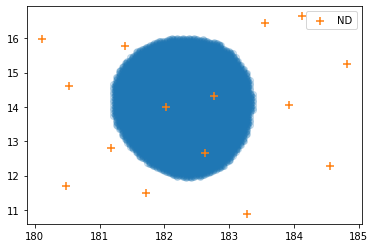

In [137]:
plt.scatter(ra_map, dec_map, alpha=0.2)
plt.scatter(a['DARK']['RA'], a['DARK']['DEC'], label='ND', alpha = 1, marker="+", s = 80) #s=4, alpha=0.7)
#plt.scatter(a['BACKUP']['RA'], a['BACKUP']['DEC'], label='ND', alpha = 1, marker="+", s = 80) #s=4, alpha=0.7)
#plt.scatter(a['BRIGHT']['RA'], a['BACKUP']['DEC'], label='ND', alpha = 1, marker="+", s = 80) #s=4, alpha=0.7)
#plt.scatter(b['DARK']['RA'], b['DARK']['DEC'], label='Interp', alpha=0.5, marker="o")
#plt.scatter(c['RA'], c['DEC'], label='old', alpha=0.5, marker="x")
plt.legend()

## ALERCE and CI Target Matching
Finds Supernova (SN) and Active Galactic Nuclei (AGN) matches in ALERCE alert broker data and matches to x% probability angles from above

In [92]:
# agn_old_alerts = alerce_client.query_objects(classifier='stamp_classifier',
#                                            class_name='AGN', 
#                                            order_by='firstmjd',
#                                            order_mode='ASC',
#                                            page_size=5000,
#                                            firstmjd=gw_mjd,
#                                            ra=218,
#                                            dec=36.5,
#                                            radius=7200,
#                                            format='pandas')
days_forward = 30

alerts_agn = access_alerts(ra = ra_degraded, dec = dec_degraded, 
                        class_names = ['AGN'], 
                        firstmjd = gw_mjd, 
                        days_forward = days_forward)

#mask=(agn_old_alerts['firstmjd']<gw_mjd+30)
#alerts_agn_2019=agn_old_alerts[mask]

In [88]:
alerts_sn = access_alerts(ra = ra_degraded, dec = dec_degraded, 
                        class_names = ['SN'], 
                        firstmjd = gw_mjd, 
                        days_forward = days_forward)

In [93]:
alerts_sn_ra = alerts_sn['meanra'].to_numpy()
alerts_sn_dec = alerts_sn['meandec'].to_numpy()

alerts_agn_ra = alerts_agn['meanra'].to_numpy()
alerts_agn_dec = alerts_agn['meandec'].to_numpy()

print("Number of SN alerts:", alerts_sn_ra.size)
print("Number of AGN alerts:", alerts_agn_ra.size)

Number of SN alerts: 8
Number of AGN alerts: 29


In [95]:
# Convert ALERCE data to pixel locations on GW map for ease of comparison (since CI pixel range is continuous, no fancy matching necessary)
transient_pix_locs_sn = hp.ang2pix(gw_properties["nside"], alerts_sn_ra, alerts_sn_dec, lonlat = True, nest = gw_properties["nest"])
transient_pix_locs_agn = hp.ang2pix(gw_properties["nside"], alerts_agn_ra, alerts_agn_dec, lonlat = True, nest = gw_properties["nest"])

# Checks for matches in region
trans_in_prob_region_sn = np.isin(transient_pix_locs_sn, pixmap)
trans_in_prob_region_agn = np.isin(transient_pix_locs_agn, pixmap)

if np.any(trans_in_prob_region_sn):
    #print("Any SN matches?", np.any(trans_in_prob_region_sn))
    print(trans_in_prob_region_sn.sum(), "SN matches")
    print(trans_in_prob_region_agn.sum(), "AGN matches")
else:
    print("No matches found.")
    #print(*zip(ra_degraded,dec_degraded))
    
alerce_sn_rows = alerts_sn.loc[trans_in_prob_region_sn, :].sort_values(by='firstmjd')
alerce_agn_rows = alerts_agn.loc[trans_in_prob_region_agn, :].sort_values(by='firstmjd')

No matches found.


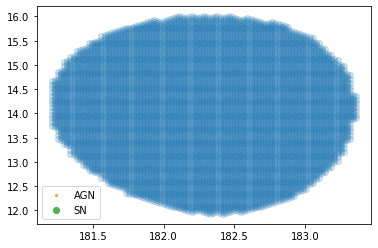

In [71]:
plt.scatter(ra_map, dec_map, alpha=0.2)
plt.scatter(alerce_agn_rows['meanra'], alerce_agn_rows['meandec'], label='AGN', s=4, alpha=0.7)
plt.scatter(alerce_sn_rows['meanra'], alerce_sn_rows['meandec'], label='SN', alpha=0.8)
plt.legend()

## Write ToO ledger to ecsv!

## Matching DESI observations to x% CI contour
This merely matches skymap angles to tile pointings and indicates which tiles matched and their program (bright/dark).

*The code does not currently write anything to file*

## The two *major* matching functions, **initial_check** and **inner_matching**
## Initial check
Performs the initial match with tile pointings. Grabs info from the exposures sql table, filters it, condenses by date, then sends all the good stuff to be matched via **inner_matching**. Finally outputs the results from that into a dictionary with the dates as keys and the sql table information as the values (sqlite3 row type, similar to a namedtuple/well-keyed dictionary). So there can be multiple elements as the values but only one key hence it's all organized by date. A convenient thing but also necessary for ALERCE efficiency.

e.g. {date:(exposure info)}

In [92]:
# From light_transient_matching, copy, pasted, and modified.

# Note, only matches 1-to-1. If you would like to find *all* matches in the area, set around = True and sit back.
# If you do set around = True, there are no data reduction methods in place yet so expect a lot of duplicates.

def initial_check(skymap_ra_in, skymap_dec_in, around = False) -> dict:
    
    # outputs a dictionary (desi_matches_dict) with keys as dates and values as sqlite3 rows containing the info grabbed from the exposures sql table
    # = {date:(exposure info)...}
    
    db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'

    # Per Antonella, no need to go further back
    query_date_start = "20201201"
    
    #today = Time.now()
    smushed_YMD = today.iso.split(" ")[0].replace("-","")
    
    query_date_end = smushed_YMD 

    # Handy queries for debugging/general information
    query2 = "PRAGMA table_info(exposures)"
    query3 = "PRAGMA table_info(tiles)"
    # Crossmatch across tiles and exposures to grab obsdate via tileid
    query_match = "SELECT distinct tilera, tiledec, obsdate, obsmjd, expid, program, \
    exposures.tileid from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        query_date_start + " AND " + query_date_end + ";" #obsdate>20210228 

    # Querying sql and returning a data type called sqlite3 row, it's kind of like a namedtuple/dictionary
    conn = sqlite3.connect(db_filename)

    conn.row_factory = sqlite3.Row # https://docs.python.org/3/library/sqlite3.html#sqlite3.Row

    cur = conn.cursor()
    
    ''' ***** For handy purposes only *****
    
     cur.execute(query2)
     row2 = cur.fetchall()
     for i in row2:
         print(i[:])
    cur.execute(query)
    rows = cur.fetchall()
    
    *********************************** '''

    cur.execute(query_match)
    matches_list = cur.fetchall()
    cur.close()

    # I knew there was a way! THANK YOU!
    # https://stackoverflow.com/questions/11276473/append-to-a-dict-of-lists-with-a-dict-comprehension
    date_dict = {k['obsdate'] : list(filter(lambda x:x['obsdate'] == k['obsdate'], matches_list)) for k in matches_list}


    desi_matches_dict = {} # {i['obsdate']: [] for i in matches_list}
    all_confidence_matches = []
    
    # Uncomment the exp_ras/decs lines if retaining said coordinates is of interest (say for scatter plotting)
    # Or make a new function parameter... I quite like how clean it is now but up to you future user
    #all_exp_ras = []
    #all_exp_decs = []
    
    # Iterating day by day as a way to keep track
    for date, row in date_dict.items():
        #print(date)
        
        date_str = str(date)
        date_str = date_str[:4]+"-"+date_str[4:6]+"-"+date_str[6:] # Adding dashes for Time
        obs_mjd = Time(date_str).mjd

        # This method is *technically* safer than doing a double list comprehension with set albeit slower
        # The lists are small enough that speed shouldn't matter here
        # row has a separate element for all the tiles on that date
        unique_tileid = {i['tileid']:(i['tilera'], i['tiledec']) for i in row}
        exposure_ras, exposure_decs = zip(*unique_tileid.values())
        #all_exp_ras.extend(exposure_ras)
        #all_exp_decs.extend(exposure_decs)
        
        # **** Old method, deprecated ****
        #unique_ra_dec = list(set([(i[0], i[1]) for i in row])) # there's probably a way to do this in SQL... oh well
        #exposure_ras, exposure_decs = zip(*unique_ra_dec)
        # ********************************
        
        # Some renaming still to be done...
        #print(date)
        # Sends all the prepared information above to be matched and retains the coordinates of the matches
        desi_matches, confidence_matches = inner_matching(exposure_ras_in = exposure_ras, exposure_decs_in = exposure_decs, 
                                                              ra_in = skymap_ra_in, dec_in = skymap_dec_in, 
                                                              query_dates = query_date_start + query_date_end,
                                                              max_sep = 2, sep_units = 'deg', around = around)
        
        if desi_matches.size: # Interchangeable with confidence_matches
            # If any matches, print!
            print(date, '-', len(confidence_matches), 'match(es)')
            #print(len(confidence_matches), 'match(es)')
            if not around:
                all_confidence_matches.extend(confidence_matches) 
        else:
            continue

        desi_matches_dict[date] = []

        # Prepping output
        # Populating the dictionary by date (a common theme)
        # Each element in the dictionary thus contains the entire sqlite3 row (all info from sql tables with said headers)
        for tup in desi_matches:
            ra = tup.ra.deg
            dec = tup.dec.deg
            match_rows = [i for i in row if (i['tilera'], i['tiledec']) == (ra, dec)] # Just rebuilding for populating, this shouldn't change/exclude anything
            desi_matches_dict[date].extend(match_rows)
            
    return desi_matches_dict, all_confidence_matches #, all_exp_ras, all_exp_decs

## inner_matching
#### AKA 'the bread & butter'

**inner_matching** does the actual matching via **match_coordinates_sky**. It outputs a SkyCoord array containing the 1-to-1 matches for DESI and whatever the second 'catalog' is. 

It handles a little bit of prep including removing NaNs but for the most part simply performs the match and spits it back.

In [67]:
# Perform the actual matching with a bit of pre-conditioning to ensure happiness for everyone involved (looking at you astropy)
def inner_matching(exposure_ras_in = np.array([]), exposure_decs_in = np.array([]), ra_in = np.array([]), dec_in = np.array([]), 
                   max_sep = 2, sep_units = 'deg', around = False, query_dates = ""):
    
    # hashtag units
    if sep_units == 'arcsec':
        max_sep *= u.arcsec
    elif sep_units == 'arcmin':
        max_sep *= u.arcmin
    elif sep_units == 'deg':
        max_sep *= u.deg
    else:
        print("Separation unit specified is invalid for matching. Defaulting to arcsecond.")
        max_sep *= u.arcsec
    
    # Just in case
    if not np.array(exposure_ras_in).size:
        print('Array of size 0 fed in. Returning no matches.')
        return np.array([]), np.array([])
    
    # Removing nans because they don't place nice in match_coordinates_sky
    nan_ra = np.isnan(exposure_ras_in)
    nan_dec = np.isnan(exposure_decs_in)
    
    if np.any(nan_ra) or np.any(nan_dec):
        print("NaNs found, removing them from array (not FITS) before match.")
        #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
        nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
        exposure_ras_in = exposure_ras_in[nans] # Logic masking, probably more efficient
        exposure_decs_in = exposure_decs_in[nans]
    
    # Sometimes this comes in handy but the code runs fast enough these days
    tree_name = "_".join(("kdtree", query_dates))
    
    desi_coords = SkyCoord(exposure_ras_in*u.deg, exposure_decs_in*u.deg)
    catalog_coords = SkyCoord(ra_in*u.deg, dec_in*u.deg)
    
    # When running against the targlist this goes crazy... not worth it but I'll keep it in for posterity
    # Lots of repeats and not yet filtered because it may not be necessary to ever use this
    if around: 
        idx_desi, idx_catalog, d2d, d3d = catalog_coords.search_around_sky(desi_coords, max_sep)
        
        desi_matches = desi_coords[idx_desi] 
        catalog_matches = catalog_coords[idx_catalog]
        
    else:
        idx_catalog, d2d, d3d = match_coordinates_sky(desi_coords, catalog_coords) #, storekdtree = tree_name) # store tree to speed up subsequent results

        sep_constraint = d2d < max_sep
        desi_matches = desi_coords[sep_constraint]
        catalog_matches = catalog_coords[idx_catalog[sep_constraint]]
    
    
    #if desi_matches.size:
    #    print(len(desi_matches), "match(es) found with separation -", max_sep)
        #print()

    return desi_matches, catalog_matches

## Matching CI interval pixel locations to DESI tile pointings

In [95]:
#desi_matches, confidence_matches = initial_check(ra_map, dec_map)
desi_matches, _ = initial_check(ra_map, dec_map)

20210318 - 2 match(es)
20210319 - 2 match(es)
20210321 - 1 match(es)
20210403 - 1 match(es)
20210404 - 2 match(es)
20210405 - 1 match(es)
20210406 - 2 match(es)
20210407 - 1 match(es)
20210408 - 1 match(es)
20210409 - 1 match(es)
20210410 - 2 match(es)
20210412 - 2 match(es)
20210413 - 3 match(es)
20210414 - 2 match(es)
20210415 - 1 match(es)
20210416 - 2 match(es)
20210418 - 1 match(es)
20210419 - 1 match(es)
20210420 - 2 match(es)
20210428 - 2 match(es)
20210430 - 2 match(es)
20210501 - 1 match(es)
20210505 - 1 match(es)
20210506 - 1 match(es)
20210507 - 1 match(es)
20210514 - 3 match(es)
20210516 - 2 match(es)
20210519 - 2 match(es)
20210606 - 1 match(es)
20210620 - 1 match(es)
20210621 - 1 match(es)
20210708 - 2 match(es)
20220120 - 1 match(es)
20220124 - 1 match(es)
20220125 - 2 match(es)
20220126 - 1 match(es)
20220217 - 1 match(es)
20220221 - 3 match(es)
20220317 - 1 match(es)
20220321 - 1 match(es)
20220402 - 4 match(es)
20220409 - 2 match(es)
20220416 - 1 match(es)
20220417 - 

## Print matched tile info (and Bright/Dark)
To be used later for plotting

## DR9 Targetlist Handling
This uses the same matching philosophy as in *light_transient_matching* in that it finds matches to tile pointings and then performs a second stage check to find individual targets. Two methods are offered, matching by RA/DEC and matching by TargetID. As mentioned earlier, RA/DEC seems more robust.

The target lists are built in the same way as [Segev's code](https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb)


### Deprecated

In [69]:
# Read useful data from fits file, RA, DEC, target ID, and mjd as a leftover from previous use 
def read_fits_info(filepath: str, tile = True):
    
    if not tile:
        hdu_num = 5
    else:
        hdu_num = 2 # Zbest? This should be 2 for that
    
    try:
        with fits.open(filepath) as hdu1:
    
            data_table = Table(hdu1[hdu_num].data) #columns
        
            targ_ID = data_table['TARGETID']
            targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            targ_dec = data_table['TARGET_DEC'].data
            
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
            # if not tile: 
            #     targ_mjd = hdu1[hdu_num].header['MJD-OBS'] # This is a string
            # else:
            #     targ_mjd = data_table['MJD'].data
            #     targ_mjd = Time(targ_mjd[0], format = 'mjd')
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        #print("In path:", filepath)
        #print("Trying the next file...")
        return np.array([]), np.array([]), np.array([])
    
    return targ_ra, targ_dec, targ_ID #targ_mjd, targ_ID

In [70]:
# Grabbing the frame fits files
def glob_frames(exp_d: str):   
    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob(exp_d + "/cframe-" + color_band + "*.fits") # Only need one of b, r, z
        # sframes not flux calibrated
        # May want to use tiles... coadd (will need later, but not now)
    except:
        try:
            # Unsure if this is necessary but in looking in some directories, there are no cframes...
            # Put this here but the issue may have been somewhere else
            # TODO: Ask Antonella
            filenames_read = glob(exp_d + "/frame-" + color_band + "*.fits") # Only need one of b, r, z
        except:
            print("Could not grab/find any fits in the exposure directory:")
            print(exp_d)
            filenames_read = [] # Just in case
            #filenames_out = [] # Just in case
            raise SystemExit("Exitting.")

    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

## Closer checking (handler) function
In the algorithm, **initial_check** has already been run and has produced a dictionary of DESI matches and 1-to-1 targetlist matches. Using said dictionary, we only check the dates/tiles in which we found a match and then compare all 5000 fibers to the whole targetlist again to save on operation time and memory.

This function handles via **glob_frames** and **read_fits_info** FITS I/O and feeds that directly into **inner_matching** to perform the actual match. So technically it doesn't actually perform the matching but it's the handler. 

It ultimately outputs two lists, one with the DESI exposure matches and the other with matches to the second catalog. In this case, the first (DESI) isn't needed so that will be all but empty while the second has the necessary info.

In [90]:
def closer_check(matches_dict = {}, catalog2_ras = [], catalog2_decs = [], exclusion_list = []):
    
    # Initalizing output structures
    all_exp_matches = {}
    all_targlist_matches = []
    
    # Just in case
    if not matches_dict:
        print("No far matches fed in for nearby matching. Returning none.")
        return {}
    
    # Iterate through dictionary from initial_check
    for date, row in matches_dict.items(): 
        print("\n", date)
        
        # If I have to run this multiple times, I probably already know what days there won't be a match so this is to save time
        if date in exclusion_list:
            continue

        all_exp_matches[date] = []
        file_indices = {}

        all_targ_ras = np.array([])
        all_targ_decs = np.array([])

        # Iterating tile by tile and grabbing all of the necessary info
        for i in row:
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), f"{str(i['expid']):0>8}"))
            #print(exp_paths)
            
            # Now finally going file by file and putting all of those ras/decs into one giant numpy array
            # It should start making sense why we go date by date now... :)
            for path in glob_frames(exp_paths):
                #print(path)
                targ_ras, targ_decs, _ = read_fits_info(path, tile = False)

                # For comparing to data tables in original file/sanity checking
                all_len = len(all_targ_ras)
                new_len = len(targ_ras)
                if all_len:
                    all_len -= 1
                    file_indices[path] = (all_len, all_len + new_len) # The start and end index, modulo number
                else:
                    file_indices[path] = (0, new_len) # The start and end index, modulo number

                if len(targ_ras) != len(targ_decs):
                    print("Length of all ras vs. all decs do not match.")
                    print("Something went wrong!")
                    print("Continuing but not adding those to match...")
                    continue

                all_targ_ras = np.append(all_targ_ras, targ_ras)
                all_targ_decs = np.append(all_targ_decs, targ_decs)

        # Here we finally perform the match, re-using inner_matching but with a much more strict matching radius
        desi_dict_matches, targlist_fiber_matches = \
            inner_matching(exposure_ras_in = all_targ_ras, exposure_decs_in = all_targ_decs,
                ra_in = catalog2_ras, dec_in = catalog2_decs, 
                max_sep = 1, sep_units = 'arcsec', around = False, query_dates = "")

        if targlist_fiber_matches:
            print(len(targlist_fiber_matches), "matches")
            all_targlist_matches.extend(targlist_fiber_matches)
        else:
            print("No matches found. Continuing...")
            continue
        
        # Prepping the output -- Not used here but kept for posterity
        '''
        for match_idx in range(len(desi_dict_matches)):
            match_ra = desi_dict_matches[match_idx].ra.deg
            match_dec = desi_dict_matches[match_idx].dec.deg
            
            # Since it's a pain to retrieve the index from the table, it'll be easier to match it after the fact with np.where
            location = np.where(match_ra == all_targ_ras)[0][0] # VERY unlikely to have a duplicate in the RA, I think this is safe
            
            targlist_ra = targlist_fiber_matches[match_idx].ra.deg
            targlist_dec = targlist_fiber_matches[match_idx].dec.deg
        
            # Prepping for DESI match output
            # Not really used here but kept for posterity
            for k, v in file_indices.items():
                if location in range(v[0], v[1]):
                    
                    # filepath, (ra,dec) for match, loc + 1 because fits indexing starts at 1, (RA, DEC) for targlist
                    match_info = (k.split("/")[-1], (match_ra, match_dec), (location + 1) % (v[1] - v[0]), (targlist_ra, targlist_dec))
                    
                    if match_info not in all_exp_matches[date]:
                        all_exp_matches[date].append(match_info)
        ''' 
    return all_exp_matches, all_targlist_matches

## Building the DR9 targetlist 

In [72]:
# Borrowed from Segev's code, thanks Segev! 
# https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb

def build_targlist_table(nside, pix_map):
    hpdirnames = ['/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright',
                  '/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark']

    readcols = ['TARGETID', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID',
                'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH',
                'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET',
                'FLUX_G', 'FLUX_R', 'FLUX_Z',
                'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z']

    targlist_threshold = None
    for hpdirname in hpdirnames:
        if targlist_threshold is None:
            targlist_threshold = Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols))
        else:
            targlist_threshold = vstack([targlist_threshold, Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols))])

    # targlist90.rename_column('BRICK_OBJID', 'OBJID')
    targlist_threshold = unique(targlist_threshold)
    
    return targlist_threshold

In [73]:
def targlist_write(table_in, filename, overwrite = True):
    # building the table takes *forever*
    # if overwrite = True, then overwrites regardless... 
    # if false, checks if the tables are equivalent and does nothing if they are
    # otherwise appends a 1 to the filename and writes
    # So if this were to happen a bunch you'd have xyz1111111.ecsv ;)
    
    if not overwrite:
        try:
            table_read = Table.read(filename)
        except:
            print("Can't find table specified per", filename)
            print("Writing a new one to", filename)
            overwrite = True

    if overwrite:
        table_in.write(filename, overwrite = True)
        
    else:
        if setdiff(table_in, table_read): # If there are differences
            name, ext = filename.split('.')
            name += "1"
            table_in.write(".".join((name, ext)))
    
    return None

In [50]:
# Some nifty commands for revisiting/rebuilding after the kernel has shutdown

rebuild = False
write_new = False
overwrite = False
read_in = True

trg_file = '/global/u2/p/portmanm/targetlists/'+ gw_name + str(CI_val) + '_dr9.ecsv'

if rebuild:
    targlist = build_targlist_table(gw_properties["nside"], pixmap)

if write_new:
    targlist_write(targlist, trg_file, overwrite)
    
if read_in:
    targlist = Table.read(trg_file)

Can't find table specified per /global/u2/p/portmanm/targetlists/GW1904120.9_dr9.ecsv
Writing a new one to /global/u2/p/portmanm/targetlists/GW1904120.9_dr9.ecsv


## Initial matching via tile pointings then close match via fibers

In [93]:
m_dict, _ = \
    initial_check(np.array(targlist['RA']), np.array(targlist['DEC']))
#targlist_matches_red = \
#    SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_matches])), unit = 'deg')

20210318 - 2 match(es)
20210319 - 2 match(es)
20210321 - 1 match(es)
20210403 - 1 match(es)
20210404 - 2 match(es)
20210405 - 1 match(es)
20210406 - 2 match(es)
20210407 - 1 match(es)
20210408 - 1 match(es)
20210409 - 1 match(es)
20210410 - 2 match(es)
20210412 - 2 match(es)
20210413 - 3 match(es)
20210414 - 2 match(es)
20210415 - 1 match(es)
20210416 - 2 match(es)
20210418 - 1 match(es)
20210419 - 1 match(es)
20210420 - 2 match(es)
20210428 - 2 match(es)
20210430 - 2 match(es)
20210501 - 1 match(es)
20210505 - 1 match(es)
20210506 - 1 match(es)
20210507 - 1 match(es)
20210514 - 3 match(es)
20210516 - 2 match(es)
20210519 - 2 match(es)
20210606 - 1 match(es)
20210620 - 1 match(es)
20210621 - 1 match(es)
20210708 - 2 match(es)
20220120 - 1 match(es)
20220124 - 1 match(es)
20220125 - 2 match(es)
20220126 - 1 match(es)
20220217 - 1 match(es)
20220221 - 3 match(es)
20220317 - 1 match(es)
20220321 - 1 match(es)
20220402 - 4 match(es)
20220409 - 2 match(es)
20220416 - 1 match(es)
20220417 - 

In [96]:
bd_tile_ras = []
bd_tile_decs = []
bd_program_info = []
bd_tileids = []

targetlist_tile_ras = []
targetlist_tile_decs = []
targetlist_program_info = []
targetlist_tileids = []

program_list = ['BRIGHT', 'DARK', 'BGS', 'ELG', 'QSO', 'LRG']
#print(len(desi_matches), len(m_dict)) # The *should* be the same length... right?

for i in range(np.max((len(desi_matches), len(m_dict)))):
    #try:
    for j in list(desi_matches.values())[i]:
        p_name = j['program']
        # We check against tileids now instead of taking them out later so that
        # everything is retained in order
        if any(substring in p_name.upper() for substring in program_list) and j['tileid'] not in bd_tileids:
            bd_tile_ras.append(j['tilera'])
            bd_tile_decs.append(j['tiledec']) 
            bd_program_info.append(p_name)
            bd_tileids.append(j['tileid'])
    #except:
    #    pass
    #try:
    for j in list(m_dict.values())[i]:
        p_name = j['program']
        if any(substring in p_name.upper() for substring in program_list) and j['tileid'] not in targetlist_tileids:
            targetlist_tile_ras.append(j['tilera'])
            targetlist_tile_decs.append(j['tiledec']) 
            targetlist_program_info.append(p_name)
            targetlist_tileids.append(j['tileid'])
    #except:
    #    pass
print(len(targetlist_tile_ras), len(bd_tile_ras))

47 47
61 61


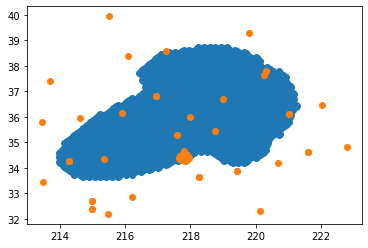

In [97]:
# Plotting the CI pixel map against the matched tiles from DESI
# These are only matched within 2 deg so edge matches are to be expected
plt.scatter(ra_map, dec_map)
plt.scatter(bd_tile_ras, bd_tile_decs)

In [98]:
# As a reminder, uses original targlist data to find 1 arcsecond matches to individual targets via fibers
desi_target_matches, targlist_target_matches = \
    closer_check(matches_dict = m_dict, catalog2_ras = np.array(targlist['RA']), \
    catalog2_decs =  np.array(targlist['DEC']))

# For when 'around = True'... but as commented earlier, that's a *bad* idea in this case
    #closer_check(matches_dict = m_dict, catalog2_ras = targlist_matches.ra.deg, \
    #catalog2_decs = targlist_matches.ra.deg)


 20210318
256 matches

 20210319
512 matches

 20210321
150 matches

 20210403
93 matches

 20210404
326 matches

 20210405
NaNs found, removing them from array (not FITS) before match.
2337 matches

 20210406
NaNs found, removing them from array (not FITS) before match.
2271 matches

 20210407
NaNs found, removing them from array (not FITS) before match.
2058 matches

 20210408
NaNs found, removing them from array (not FITS) before match.
2058 matches

 20210409
NaNs found, removing them from array (not FITS) before match.
1989 matches

 20210410
NaNs found, removing them from array (not FITS) before match.
4450 matches

 20210412
NaNs found, removing them from array (not FITS) before match.
5874 matches

 20210413
NaNs found, removing them from array (not FITS) before match.
7662 matches

 20210414
NaNs found, removing them from array (not FITS) before match.
5107 matches

 20210415
NaNs found, removing them from array (not FITS) before match.
1361 matches

 20210416
NaNs found, rem

In [100]:
# Some data reduction to avoid repeats (there's quite a lot!)
unique_targlist_target_matches = \
    SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_target_matches])), unit = 'deg')
# targetid
print(len(targlist))
print(len(targlist_target_matches))
print(len(unique_targlist_target_matches))

102399
140653
55257


## Reducing the targetlist by previous observations

In [101]:
# Convert targetlist matches to a Table to take advantage of astropy's setdiff method
tlist_matches_table = Table([SkyCoord(unique_targlist_target_matches).ra.deg, 
                             SkyCoord(unique_targlist_target_matches).dec.deg], names = ('RA', 'DEC'))

#print(Table(targlist_matches))
targlist_radec_reduced = setdiff(targlist['RA', 'DEC'], tlist_matches_table)

assert len(targlist_radec_reduced) == len(targlist) - len(unique_targlist_target_matches), "Something went wrong masking the dr9 target list! Stopping."
print('{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {} CI.'.format(100*len(unique_targlist_target_matches)/len(targlist), CI_val))

53.96% of targets have already been observed within 2 degrees of DESI tile pointing in 0.9 CI.


In [102]:
 len(targlist_radec_reduced)

47142

## Writing to ToO ecsv

This may take awhile, it's likely a lot of targets that we have yet to observe.

In [103]:
#targlist_write(targlist_radec_reduced, "dr9_targlist" + CI_val + "_reduced_radec.ecsv", overwrite = True)

In [104]:
# Write dr9 targets to ecsv
#write_too_ledger(filename = 'testing_ToO-bgs.ecsv', too_table = targlist_radec_reduced.to_pandas(), checker='MP/AP', overwrite=True, verbose=False, tabformat='LEGACY')

## Reduce targetlist using targetid

Seemingly less robust than RA/DEC but still worth holding onto. Somewhat faster but not as fast as one might hope (there is probably a quicker method to doing this however so don't take my word on speed until that alternative has been fully investigated (if it is ever investigated)) 

In [105]:
# Operates in a similar fashion to closer_check, just with targetids
# Also uses setdiff because I like it and I can iteratively reduce the original targetlist with little fuss and have it done
def grab_desi_targetid(matches_dict = {}, targlist_table = Table(), exclusion_list = []):
    
    if not targlist_table:
        print("No targetlist table fed in. Exitting and returning empty table.")
        return targlist_table
    
    if not matches_dict:
        print("No far matches fed in for targetid matching. Returning an empty table.")
        return Table()
    
    # For calling setdiff
    # I don't overwrite targlist_table... just in case... out of habit... because I'm scared
    table_reduced_targids = targlist_table
    
    for date, row in matches_dict.items(): 
        
        print(date)
        if date in exclusion_list:
            continue
            
        target_ids_date = []

        for i in row:
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), f"{str(i['expid']):0>8}"))
            #print(exp_paths)
            #all_exp_fits[date].extend()
            for path in glob_frames(exp_paths):
                #print(path)
                _, _, target_ids = read_fits_info(path, tile = False)

                target_ids_date.extend(target_ids)

        # Convert targetids to astropy table
        target_ids_date = np.array(target_ids_date, dtype = 'longlong')
        DESI_targ_id_table = Table([target_ids_date], names = ['TARGETID'])
        #targetid_matches = setdiff(targlist_table['TARGETID'], DESI_targ_id_table)
        
        # Perform setdiff
        reduced_targids = setdiff(table_reduced_targids, DESI_targ_id_table, keys = ['TARGETID'])
        if reduced_targids: # Since setdiff will return an empty table if there are no matches... which would overwrite everything
            table_reduced_targids = reduced_targids 
        else:
            print("No targetid matches found on:", date)
            
    return table_reduced_targids

In [106]:
targlist_targetid_reduced = grab_desi_targetid(matches_dict = m_dict, targlist_table = targlist, exclusion_list = [])

20210318
20210319
20210321
20210403
20210404
20210405
20210406
20210407
20210408
20210409
20210410
20210412
20210413
20210414
20210415
20210416
20210418
20210419
20210420
20210428
20210430
20210501
20210505
20210506
20210507
20210514
20210516
20210519
20210606
20210620
20210621
20210708
20220120
20220124
20220125
20220126
20220217
20220221
20220317
20220321
20220402
20220409
20220416
20220417
20220420
20220421
20220426


In [107]:
print(len(targlist))
print(len(targlist_targetid_reduced))

print('{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {} CI.'.format(100*(len(targlist) - len(targlist_targetid_reduced))/len(targlist), CI_val))

102399
48737
52.40% of targets have already been observed within 2 degrees of DESI tile pointing in 0.9 CI.


In [108]:
print("Length of targetlist reduced by radec: ", len(targlist_radec_reduced))
print("Length of targetlist reduced by targetid: ", len(targlist_targetid_reduced))

Length of targetlist reduced by radec:  47142
Length of targetlist reduced by targetid:  48737


## Writing to ToO ecsv

In [109]:
# Print reduced targlist to file
#targlist_write(targlist_targetid_reduced, "dr9_targlist" + CI_val +"_reduced_targetid.ecsv", overwrite = True)
#write_too_ledger(filename = 'testing_by_targetid_ToO-bgs.ecsv', too_table = targlist_targetid_reduced.to_pandas(), checker='MP/AP', overwrite=True, verbose=False, tabformat='LEGACY')

## Plotting GW map things

These take awhile so I placed them at the bottom so as to avoid accidentally running them and having to wait.

## Plot Cartmap for tiles and FOV in CI contour

Plots contours of CIs, Bright/Dark pointings, DESI FOV, and lastly saves!

In [110]:
# Borrowed from gw_skymap.py and modified

def plot_cartmap_tiles(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None, program_names = None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')
    
    bright_list = ['BRIGHT', 'BGS']
    dark_list = ['DARK', 'ELG', 'QSO', 'LRG']
    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        if program_names:
            
            # if bright in program_info or if '---'.lower() == bgs, then plot as bright
            # if dark in ... or if ''.lower() == elg or qso or lrg
            
            bright_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in bright_list)])
            dark_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in dark_list)])
            
            bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha = 1, label = 'BRIGHT', marker = "+") 
            dark_dots = ax.plot(dark_pointing[:, 0], dark_pointing[:, 1], 'm.', alpha = 0.7, label = 'DARK', marker = "x") 
            
        else:
            ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5, label = 'Matches') # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    _h, _l = ax.get_legend_handles_labels()

    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra is not None and tile_dec is not None:
        #for _ra_c, _dec_c in zip(tile_ra, tile_dec):
        for _ra_c, _dec_c in zip(targ_ra, targ_dec):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
            ax.add_artist(circ)

        _h.append(circ)
        _l.append('DESI FOV')
    
    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

/tmp/ipykernel_43034/94711184.py:74: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))
/tmp/ipykernel_43034/94711184.py:74: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))
/tmp/ipykernel_43034/94711184.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "c." (-> marker='.'). The keyword argument will take precedence.
  bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha = 1, label = 'BRIGHT', marker = "+")
/tmp/ipykernel_43034/94711184.py:94: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt

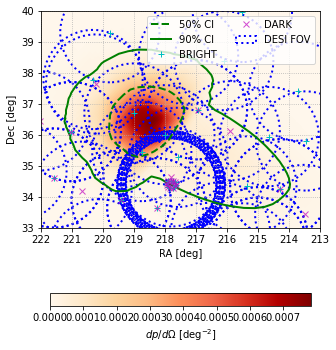

In [111]:
fig = plot_cartmap_tiles(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = bd_tile_ras, targ_dec = bd_tile_decs, angsize = 5, program_names = bd_program_info)
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,40))
#ax.scatter(exp_ras, exp_decs)
#ax.scatter(targlist_radec_reduced['RA'], targlist_radec_reduced['DEC'], alpha = 0.2, s = 0.3)
plt.savefig(gw_name + '_desi_tile-matches.png', dpi=120)

/tmp/ipykernel_43034/94711184.py:74: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))
/tmp/ipykernel_43034/94711184.py:74: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))


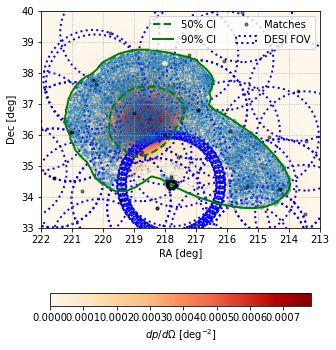

In [112]:
# Plot targetlist tile matches and DESI FOV, just in case 
fig = plot_cartmap_tiles(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = targetlist_tile_ras, targ_dec = targetlist_tile_decs, angsize = 5, program_names = [])#program_info)
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,40))
ax.scatter(targlist_radec_reduced['RA'], targlist_radec_reduced['DEC'], alpha = 0.2, s = 0.3)
#ax.scatter(targlist['RA'], targlist['DEC'])
plt.savefig(gw_name + '_desi_tile-matches.png', dpi=120)